# PyTorch Custom Datasets

We've used some dataset with PyTorch before

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets

Depending on we're working on, vision, text, audio, recocmendation, we can look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

## Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Tue Sep  5 13:28:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get Data

Our dataset is a subset of the Food101 dataset

Food101 start 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images. (~75 training, 25 testing)

Why?

When starting out ML Projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast we can experiment

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"febryanputrakartika","key":"076b230b9d6c9bf44a847715914b517e"}'}

In [5]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [6]:
!kaggle datasets download -d alifrahman/covid19-chest-xray-image-dataset

 99% 40.0M/40.6M [00:03<00:00, 20.2MB/s]
100% 40.6M/40.6M [00:03<00:00, 11.1MB/s]


In [7]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')

# Download pizza, steak and sushi data
#with open(data_path/'xray.zip', 'wb') as f:
#  request = requests.get('https://www.kaggle.com/datasets/alifrahman/covid19-chest-xray-image-dataset/download?datasetVersionNumber=1')
#  print('Downloading xray data...')
#  f.write(request.content)

# Unzip data
with zipfile.ZipFile('covid19-chest-xray-image-dataset.zip', 'r') as zip_ref:
  print('Unzipping covid19 data...')
  zip_ref.extractall(data_path)

Unzipping covid19 data...


# 2. Becoming one with the data (data preparation and data exploration)

In [8]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(data_path)

There are 1 directories and 0 images in 'data'.
There are 2 directories and 0 images in 'data/dataset'.
There are 0 directories and 25 images in 'data/dataset/normal'.
There are 0 directories and 69 images in 'data/dataset/covid'.


# 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/dataset/covid/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg
Image class: covid
Image height: 657
Image width: 657


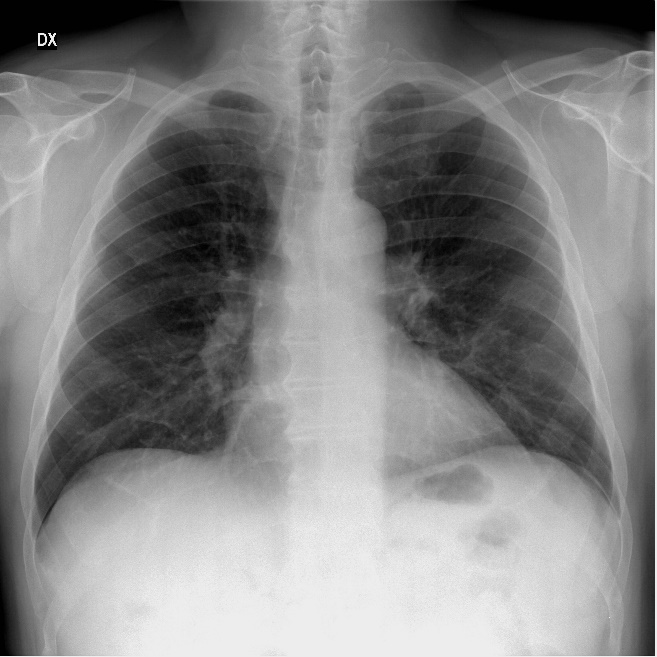

In [10]:
import random
from PIL import Image

# Set the seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(data_path.glob("*/*/*"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in this case, numerical representation of the images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turns image into grayscale
    transforms.Grayscale(num_output_channels=3),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
    # Permute the channel height and width
])

In [144]:
import cv2
import numpy as np
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
data = []
labels = []
# loop over the image paths
for imagePath in image_path_list:
    # extract the class label from the filename
    label = imagePath.parent.stem
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(str(imagePath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (224, 224))
    reshaped_image = np.expand_dims(image, axis=0)

    # update the data and labels lists, respectively
    data.append(reshaped_image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [145]:
print(data.shape)
print(labels.shape)

(94, 1, 224, 224)
(94,)


In [209]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
list(le.classes_)
le_int = le.transform(labels)

In [16]:
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # Need to permute the array into HWC since the default format for matplotlib is HWC instead of CHW
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

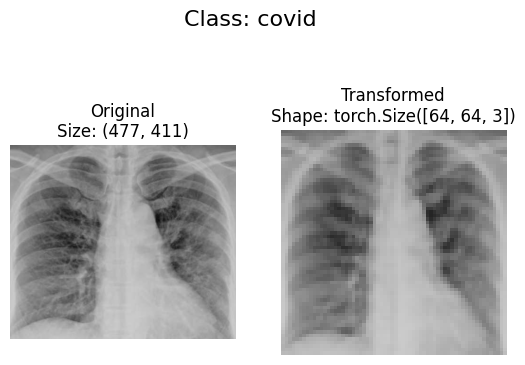

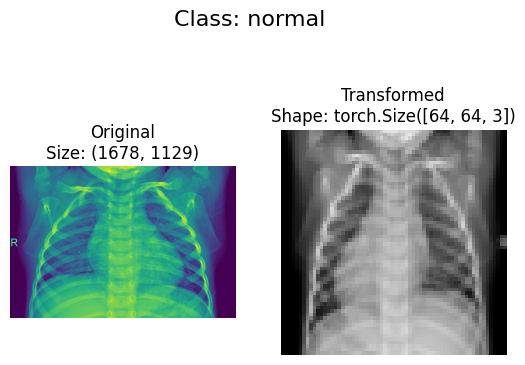

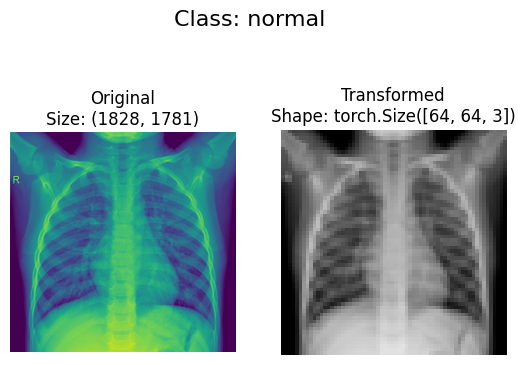

In [103]:
plot_transformed_images(image_path_list, data_transform, seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, le_int, test_size=0.2, random_state=42)

In [160]:
# Convert Array into Tensor
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.long)
X_test_tensor = torch.from_numpy(X_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.long)

train_dir = TensorDataset(X_train_tensor, y_train_tensor)
test_dir = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dir, shuffle=True)
test_dataloader = DataLoader(test_dir, shuffle=False)

In [161]:
# Let's checkout what we've created
print(f"Data Loaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Data Loaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f0191ee0730>, <torch.utils.data.dataloader.DataLoader object at 0x7f0191eadbd0>)
Length of train_dataloader: 75
Length of test_dataloader: 19


In [218]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch, train_labels_batch = train_features_batch.float(), train_labels_batch.float()
train_features_batch.shape, train_labels_batch.shape

(torch.Size([1, 1, 224, 224]), torch.Size([1]))

Image Size: torch.Size([1, 224, 224])
Label: normal


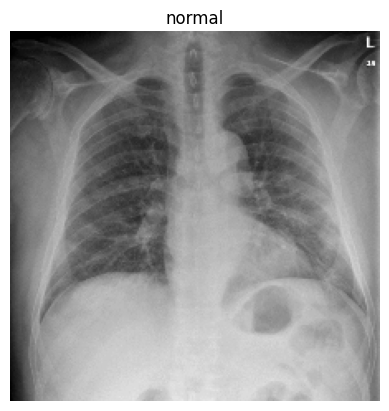

In [225]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
label = preprocessing.LabelEncoder()
label.fit(labels)
label_int = label.transform(labels)
class_names = le.inverse_transform(le_int)
le_int
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[random_idx])
plt.axis(False)
print(f"Image Size: {img.shape}")
print(f"Label: {class_names[random_idx]}")

In [283]:
class COVID19Model(nn.Module):
  def __init__(self, input:int, hidden_units:int, output:int):
    super().__init__()
    self.convolution_block_1 = nn.Sequential(
        # Create a Conv Layer
        nn.Conv2d(in_channels=input,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # These are all hyperparams
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.convolution_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=15680, # there's a trick on how to determine the in_features for linear layer after convolutional
                  out_features=output)

    )

  def forward(self, x):
    x = self.convolution_block_1(x)
    #print(x.shape)
    x = self.convolution_block_2(x)
    #print(x.shape)
    x = self.classifier_layer(x)
    return x

In [284]:
model_0 = COVID19Model(input=1, hidden_units=5, output=len(train_labels_batch)).to(device)
model_0

COVID19Model(
  (convolution_block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolution_block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=15680, out_features=1, bias=True)
  )
)

In [285]:
# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

In [286]:
# Create accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [287]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """ Performs a training loop for model trying to learn on data_loader"""
  train_acc, train_loss = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    model.to(device)
    X, y = X.to(device), y.to(device)

    # Forward Pass
    train_logits = model(X)
    train_preds = torch.round(torch.sigmoid(train_logits))


    # Calculate Loss
    loss = loss_fn(train_logits, y.float())
    train_loss += loss # accumulate train loss
    acc = accuracy_fn(y_true=y,
                      y_pred=train_preds)
    train_acc += acc

    # Optimizer Zero Grad
    optimizer.zero_grad()

    # Backprop
    loss.backward()

    # Gradient Descent
    optimizer.step()

  # Divide total train loss and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%")

In [288]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: loss_fn,
              accuracy_fn: accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop for model going over data_loader"""
  test_loss, test_acc = 0, 0

  # Set model into eval mode and inference mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to target device
      model.to(device)
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_logits = model(X)
      test_preds = torch.round(torch.sigmoid(test_logits))


      # Calculate loss and accuracy
      test_loss += loss_fn(test_logits, y.float())
      test_acc += accuracy_fn(y_true=y,
                         y_pred=test_preds)

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}% |Tested on: {device}")

In [289]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train and test model
epochs = 50
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----------")
  train_step(model_0,
             train_dataloader,
             loss_fn,
             accuracy_fn,
             optimizer,
             device)
  test_step(model_0,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-----------
Train Loss: 0.22396 | Train Accuracy: 25.33%
Test Loss: 0.22156 | Test Accuracy: 31.58% |Tested on: cuda
Epoch: 1
-----------
Train Loss: 0.22424 | Train Accuracy: 25.33%
Test Loss: 0.21529 | Test Accuracy: 31.58% |Tested on: cuda
Epoch: 2
-----------
Train Loss: 0.20748 | Train Accuracy: 25.33%
Test Loss: 0.27325 | Test Accuracy: 31.58% |Tested on: cuda
Epoch: 3
-----------
Train Loss: 0.20602 | Train Accuracy: 25.33%
Test Loss: 0.25805 | Test Accuracy: 31.58% |Tested on: cuda
Epoch: 4
-----------
Train Loss: 0.20490 | Train Accuracy: 25.33%
Test Loss: 0.24034 | Test Accuracy: 31.58% |Tested on: cuda
Epoch: 5
-----------
Train Loss: 0.20121 | Train Accuracy: 25.33%
Test Loss: 0.22046 | Test Accuracy: 31.58% |Tested on: cuda
Epoch: 6
-----------
Train Loss: 0.20223 | Train Accuracy: 25.33%
Test Loss: 0.21904 | Test Accuracy: 31.58% |Tested on: cuda
Epoch: 7
-----------
Train Loss: 0.18504 | Train Accuracy: 25.33%
Test Loss: 0.22340 | Test Accuracy: 31.58% |Tested o

In [265]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: accuracy_fn,
               device: torch.device = device):
  """ Returns a dictionary containing the results of model predicting on Data Loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Send data to target device
      X, y = X.to(device), y.to(device)
      model = model.to(device)
      # Make predictions
      y_logits = model(X)
      y_preds = torch.round(torch.sigmoid(y_logits))

      # Calculate loss and accuracy per batch
      loss += loss_fn(y_logits, y.float())
      acc += accuracy_fn(y_true=y,
                         y_pred=y_preds)

    # Scale loss and accuracy to find the average loss/accuracy per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"Model_Name": model.__class__.__name__, # only works when model was created with a class
          "Model_Loss": loss.item(),
          "Model_Acc": acc}

In [266]:
  model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn, device)

  0%|          | 0/19 [00:00<?, ?it/s]

In [267]:
model_0_results

{'Model_Name': 'COVID19Model',
 'Model_Loss': 0.03682079166173935,
 'Model_Acc': 47.36842105263158}

In [268]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):

  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device) e.g [1,28,28] to [1,1,28,28]
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward Pass (model outputs will be raw logits)
      pred_logits = model(sample)

      # Get the predictions probabilities (logits -> pred probs) since it's multiclass we use softmax activation and argmax
      pred_prob = torch.sigmoid(pred_logits)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into tensor
  return torch.stack(pred_probs)

In [269]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dir), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 224, 224])

Text(0.5, 1.0, "['normal']")

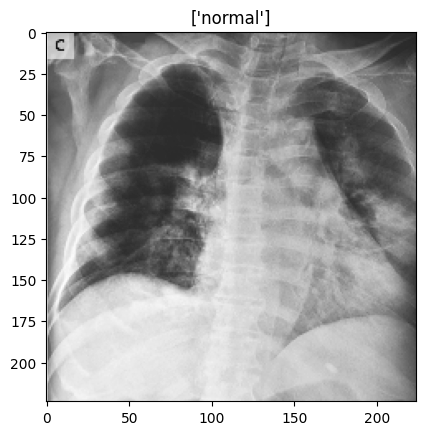

In [270]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title([class_names[test_labels[0]]])

In [271]:
# Make predictions
pred_probs = make_predictions(model_0, test_samples)

# View first two prediction probabilities
pred_probs[:]

tensor([[[0.4879]],

        [[0.5032]],

        [[0.7302]],

        [[0.5265]],

        [[0.7108]],

        [[0.4940]],

        [[0.5152]],

        [[0.6610]],

        [[0.5393]]])

In [272]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.round()
pred_classes

tensor([[[0.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[0.]],

        [[1.]],

        [[1.]],

        [[1.]]])

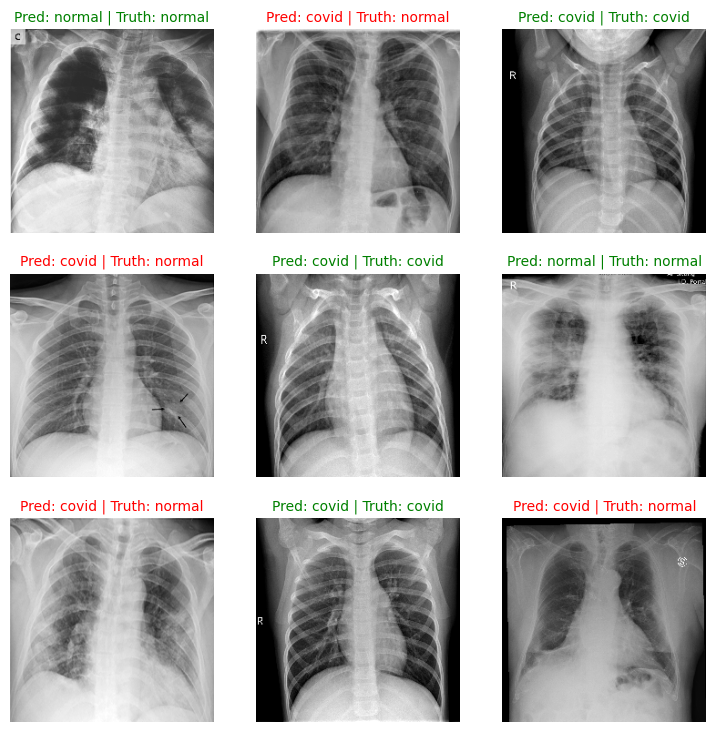

In [273]:
# Plot Predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample, in enumerate(test_samples):
  # Create a subplot for each sample
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap='gray')

  # Find the prediction lables (in text form)
  pred_label = pred_classes[i]
  if pred_label == 1:
    pred_label = 'covid'
  else:
    pred_label = 'normal'

  # Get the truth label (in text form)
  truth_label = test_labels[i]
  if truth_label == 1:
    truth_label = 'covid'
  else:
    truth_label = 'normal'

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c='g')
  else:
    plt.title(title_text, fontsize=10, c='r')

  plt.axis(False)

In [274]:
# Import tqdm.auto
from tqdm.auto import tqdm

# Make Predictions with trained model (model_2)
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc='Making Predictions...'):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn Pred Logits into Pred Probs into Pred Labels
    y_pred = torch.sigmoid(y_logit).round()
    # Put predictions on CPU for eval
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.squeeze()

Making Predictions...:   0%|          | 0/19 [00:00<?, ?it/s]

tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1.])

In [275]:
y_pred_tensor = torch.squeeze(y_pred_tensor, dim=1)
y_pred_tensor.shape

torch.Size([19])

In [70]:
# See if required packages are installed and if not, install them
try:
  import torchmetrics, mlxtend
  print(f'Mlxtend version: {mlxtend.__version__}')
  assert int(mlxtend.__version__.split(".")[1] >= 19), 'Mlxtend version should be 0.19.0 or higher'
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f'Mlxtend version: {mlxtend.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 6.0 MB/s eta 0:00:00
Mlxtend version: 0.22.0


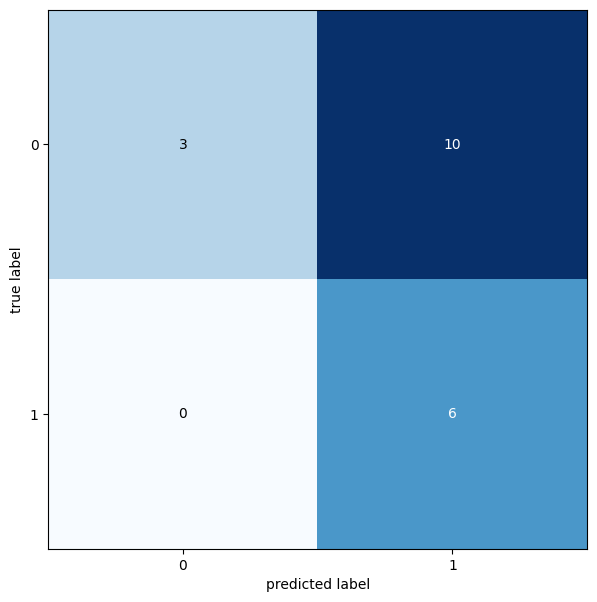

In [276]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=2, task='binary')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_test_tensor)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    figsize=(10, 7)
);